In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.8 MB/s eta 0:00:00


In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install pyg-lib -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html

2.3.0+cu121
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 8.2 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-4b5bjszb
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-4b5bjszb
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 4e01b0bca72e97aca2ec0e1edf27ec768dc16d8a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.6.0-py3-none-any.whl size=1119024 sha256=ca87921375de24fa4c4ccd3dd8fa730c88105223c295c46585a77607ae1d411e
  Stored in directory: /tmp/pip-ephem-wheel-cache-zlvkx5wa/wheels/d3/78/eb/9e26525b948d19533f1688fb6c209cec8a0ba793d39b49ae8f
Successfully built torch-geometric
  Attempting uninstall: torch-geometric
  

In [ ]:
import numpy as np
import os
import scipy
import scipy.io
import os.path as osp
from torch_geometric.data import Data
import torch
from gensim.models import Word2Vec, KeyedVectors
import torch_geometric.transforms as T
import torch.nn.functional as F
from sklearn.metrics import jaccard_score
import networkx as nx
import torch.nn as nn

In [ ]:
# connected to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_eukloc(data_name="EukaryoteGo", path='/content/drive/My Drive/data'):
    edge_list = torch.tensor(np.genfromtxt(os.path.join(path, data_name, "edge_list.csv"),
                                           skip_header=1, dtype=np.dtype(float), delimiter=','))[:, :2].long()
    edge_list_other_half = torch.hstack((edge_list[:, 1].reshape(-1, 1), edge_list[:, 0].reshape(-1, 1)))
    edge_index = torch.transpose(edge_list, 0, 1)
    edge_index_other_half = torch.transpose(edge_list_other_half, 0, 1)
    edge_index = torch.hstack((edge_index, edge_index_other_half))

    labels = np.genfromtxt(os.path.join(path, data_name, "labels.csv"),
                           dtype=np.dtype(float), delimiter=',')
    labels = torch.tensor(labels).float()

    adj = torch.sparse_coo_tensor(edge_index, torch.ones(edge_index.shape[1]),
                                  (labels.shape[0], labels.shape[0])).to_dense()

    features = torch.tensor(np.genfromtxt(os.path.join(path, data_name, "features.csv"),
                            dtype=np.dtype(float), delimiter=',')).float()

    file_path = os.path.join(path, data_name, "split.pt")
    masks = torch.load(file_path)
    train_idx = masks["train_mask"]
    train_mask = torch.zeros(features.shape[0], dtype=torch.bool)
    train_mask[train_idx] = True

    val_idx = masks["val_mask"]
    val_mask = torch.zeros(features.shape[0], dtype=torch.bool)
    val_mask[val_idx] = True

    test_idx = masks["test_mask"]
    test_mask = torch.zeros(features.shape[0], dtype=torch.bool)
    test_mask[test_idx] = True
    G = Data(x=features,
             edge_index=edge_index,
             y=labels)
    G.train_mask = train_mask
    G.val_mask = val_mask
    G.test_mask = test_mask
    #G.adj = adj
    G.num_nodes = G.x.shape[0]
    G.n_id = torch.arange(G.num_nodes)
    # embedding the label for val and test
    val_test_mask = G.val_mask + G.test_mask
    padding = torch.full((1, G.y.shape[1]), 1 / G.y.shape[1]).float()
    # Pad the rows for test and validation nodes
    label_matrix = G.y.clone().detach()
    label_matrix[val_test_mask] = padding
    G.y_pad = label_matrix
    Label_train = G.y[G.train_mask].transpose(0, 1)
    # CN * NC
    #LabelCor = torch.mm(Label_train, G.y[G.train_mask])
    #G.LabelCor = row_normalize(LabelCor)
    return G

In [ ]:
Euka = load_eukloc(data_name="EukaryoteGo", path='/content/drive/My Drive/data')
Euka

Data(x=[7766, 32], edge_index=[2, 27636], y=[7766, 22], train_mask=[7766], val_mask=[7766], test_mask=[7766], num_nodes=7766, n_id=[7766], y_pad=[7766, 22])

In [ ]:
#reading EukaryoteGo
edge_index = Euka.edge_index
G_Euka = nx.Graph()
nodes = list(range(Euka.num_nodes))
G_Euka.add_nodes_from(nodes)
edges = edge_index.t().tolist()  # 转置并转换为 Python 列表
G_Euka.add_edges_from(edges)
print("Number of nodes:", G_Euka.number_of_nodes())
print("Number of edges:", G_Euka.number_of_edges())

Number of nodes: 7766
Number of edges: 12050


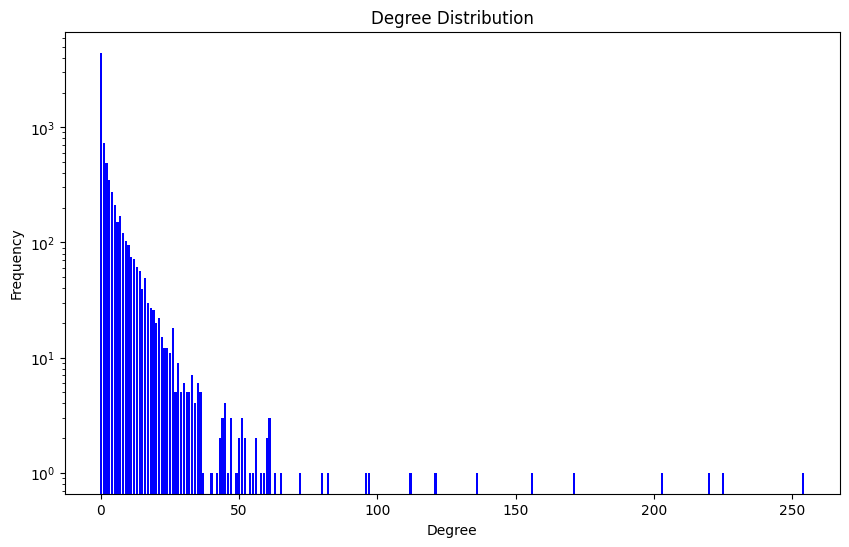

In [185]:
# 2. 计算每个节点的度
degrees = [G_Euka.degree(n) for n in G_Euka.nodes()]

# 3. 统计每个度出现的频率
degree_counts = {}
for degree in degrees:
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

# 4. 分离度和值
degree_values = list(degree_counts.keys())
counts = list(degree_counts.values())

# 5. 绘制度分布图
plt.figure(figsize=(10, 6))
plt.bar(degree_values, counts, width=0.8, color='b')

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')  # 如果需要，可以将y轴设为对数尺度

plt.show()

In [ ]:
#Spliting EukaryoteGo into largest connected component and remaining
largest_cc = max(nx.connected_components(G_Euka), key=len)
largest_subgraph = G_Euka.subgraph(largest_cc)
# 打印节点和边的数量
print("Number of nodes-lcc:", largest_subgraph.number_of_nodes())
print("Number of edges-lcc:", largest_subgraph.number_of_edges())
G_remaining = G_Euka.copy()
# 移除 G1 中的所有节点
G_remaining.remove_nodes_from(largest_subgraph.nodes)
# 移除 G1 中的所有边
G_remaining.remove_edges_from(largest_subgraph.edges)
print("Number of nodes-remaining:", G_remaining.number_of_nodes())
print("Number of edges-remaining:", G_remaining.number_of_edges())

Number of nodes-lcc: 2969
Number of edges-lcc: 11716
Number of nodes-remaining: 4797
Number of edges-remaining: 334


In [ ]:
# support = 0.0
# label_classes = []
# for edge in edges:
#     support = support + jaccard_score(labels[edge[0]].numpy(),
#                                       labels[edge[1]].numpy())
#     edge_0_label = find_occurance_class(labels[edge[0]].numpy())
#     edge_1_label = find_occurance_class(labels[edge[1]].numpy())

# h = support / len(edges)
# print(h)

In [ ]:
#计算largest connected component中的label homophily
labels = Euka.y
support = 0.0
label_classes_lcc = []
for edge in list(largest_subgraph.edges):
    support = support + jaccard_score(labels[edge[0]].numpy(),
                                      labels[edge[1]].numpy())

#不能从边上找出现过的label类，要从节点上找，因为很多节点是孤立的
h = support / largest_subgraph.number_of_edges()
print(h)

0.4314470240127457


In [ ]:
#计算remaining graph中的label homophily
support = 0.0
for edge in list(G_remaining.edges):
    support = support + jaccard_score(labels[edge[0]].numpy(),
                                      labels[edge[1]].numpy())

h = support / G_remaining.number_of_edges()
print(h)

#many self loops, 信息缺失

0.7692115768463073


In [ ]:
# 计算聚类系数（clustering coefficient）
clustering_coeff = nx.average_clustering(largest_subgraph)
# 计算链接密度（link density）
link_density = nx.density(largest_subgraph)
print(f"聚类系数: {clustering_coeff}")
print(f"链接密度: {link_density}")

聚类系数: 0.15023900995956704
链接密度: 0.002659103639676477


In [ ]:
clustering_coeff = nx.average_clustering(G_Euka)
# 计算链接密度（link density）
link_density = nx.density(G_Euka)
print(f"聚类系数: {clustering_coeff}")
print(f"链接密度: {link_density}")

聚类系数: 0.06163099243325019
链接密度: 0.000399648508307797


In [ ]:
def print_dataset_label_statistic(labels):
    # 计算每行的非零元素个数
    nonzero_counts = torch.count_nonzero(labels, dim=1)

    # 转换为浮点数类型，以便进行平均值计算
    nonzero_counts_float = nonzero_counts.float()

    # 计算非零元素个数的最小值、平均值、中位数和最大值
    min_count = torch.min(nonzero_counts).item()
    mean_count = torch.mean(nonzero_counts_float).item()
    median_count = torch.median(nonzero_counts.float()).item()
    max_count = torch.max(nonzero_counts).item()

    # 打印结果
    print("每行非零元素个数的最小值:", min_count)
    print("每行非零元素个数的平均值:", mean_count)
    print("每行非零元素个数的中位数:", median_count)
    print("每行非零元素个数的最大值:", max_count)

In [ ]:
# 最大连通量的label分布
selected_labels_largest_cc = labels[torch.tensor(list(largest_cc))]
print_dataset_label_statistic(selected_labels_largest_cc)

每行非零元素个数的最小值: 1
每行非零元素个数的平均值: 1.1855844259262085
每行非零元素个数的中位数: 1.0
每行非零元素个数的最大值: 4


In [ ]:
# 最大连通量的label分布
selected_labels_remaining = labels[torch.tensor(list(G_remaining.nodes))]
print_dataset_label_statistic(selected_labels_remaining)

每行非零元素个数的最小值: 1
每行非零元素个数的平均值: 1.1209088563919067
每行非零元素个数的中位数: 1.0
每行非零元素个数的最大值: 4


In [ ]:
def find_columns_with_ones(tensor):
    num_rows, num_cols = tensor.shape
    columns_with_ones = set()

    for row_idx in range(num_rows):
        row = tensor[row_idx]
        indices = np.where(row == 1)[0]  # 找到每行中值为1的索引
        columns_with_ones.update(indices)  # 将索引添加到集合中
    return list(columns_with_ones)

In [ ]:
columns_count_lcc = find_columns_with_ones(selected_labels_largest_cc)
print("Columns with ones count-lcc:")
columns_count_lcc

Columns with ones count-lcc:


[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [ ]:
columns_count_remaining = find_columns_with_ones(selected_labels_remaining)
print("Columns with ones count-remaining:")
columns_count_remaining

Columns with ones count-remaining:


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

From this we infer that most of topology information and classes information has been covered by largest connected components

Now we will use the topology information from largest connected component and some adding nodes from the remaining class (so the model can identify this kind of class)

In [ ]:
#only modifying training_mask, 对training_mask做进一步挑选，挑选出只在largest connected component 出现过的节点
def update_train_mask(train_mask, node_list):
    node_set = set(node_list)  # 将node_list转换为集合以便快速查找
    updated_mask = train_mask.clone()  # 复制 train_mask，以免修改原始数据
    for idx in range(train_mask.size(0)):
        if updated_mask[idx] and idx not in node_set:
            updated_mask[idx] = False
    return updated_mask

# 示例用法
# 假设 Euka.train_mask 是一个 PyTorch 张量，largest_cc 是一个列表
train_mask_lcc = update_train_mask(Euka.train_mask, list(largest_cc))
train_mask_lcc

tensor([False,  True, False,  ..., False, False, False])

In [ ]:
train_mask = Euka.train_mask
test_mask = Euka.test_mask
def count_true_values(tensor):
    return tensor.sum().item()
true_count_lcc = count_true_values(train_mask_lcc)
print("Number of True values:", true_count_lcc)
true_count_original = count_true_values(train_mask)
print("Number of True values:", true_count_original)
#训练数据大幅度缩减

Number of True values: 1620
Number of True values: 4192


In [ ]:
Euka

Data(x=[7766, 32], edge_index=[2, 27636], y=[7766, 22], train_mask=[7766], val_mask=[7766], test_mask=[7766], num_nodes=7766, n_id=[7766], y_pad=[7766, 22])

In [ ]:
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import SAGEConv
# for mini-batch training
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import Node2Vec
# For GraphSage
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(Euka.x.shape[1], hidden_channels)
        self.conv2 = GCNConv(hidden_channels, Euka.y.shape[1])

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

class GAT(nn.Module):
    def __init__(self, hidden_channels, num_heads, dropout=0.5):
        super(GAT, self).__init__()
        self.conv1 = GATConv(Euka.x.shape[1], hidden_channels, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * num_heads, Euka.y.shape[1], heads=num_heads, concat=False, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, class_channels, num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, class_channels))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = x.relu_()
                x = F.dropout(x, p=0.5, training=self.training)
        return F.sigmoid(x)

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                xs.append(x[:batch.batch_size].cpu())
            x_all = torch.cat(xs, dim=0)
        return F.sigmoid(x_all)



In [ ]:
# decide what kind of model you would like to use
#GCN
model_lcc = GCN(hidden_channels=32)
#GAT
hidden_channels = 32
num_heads = 2
gat_model_lcc = GAT(hidden_channels, num_heads)
#Graph SAGE
model_SAGE_lcc = SAGE(in_channels=Euka.x.shape[1],
                 hidden_channels=32,
                 class_channels=Euka.y.shape[1],
                 )

In [ ]:
optimizer = torch.optim.Adam(model_SAGE_lcc.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Training function
from metrics import f1_loss,_eval_rocauc,ap_score

def train_lcc(model_lcc):
    model_lcc.train()
    optimizer.zero_grad()
    out = model_lcc(Euka)
    loss = criterion(out[train_mask_lcc], Euka.y[train_mask_lcc])
    loss.backward()
    optimizer.step()
    return loss

def train_lcc_enrich(model_lcc_enrich):
    model_lcc_enrich.train()
    optimizer.zero_grad()
    out = model_lcc_enrich(Euka)
    loss = criterion(out[train_mask_lcc_enriching], Euka.y[train_mask_lcc_enriching])
    loss.backward()
    optimizer.step()
    return loss

def train_normal(model_normal):
    model_normal.train()
    optimizer.zero_grad()
    out = model_normal(Euka)
    loss = criterion(out[train_mask], Euka.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss

# Testing function
def test(model):
    model.eval()
    out = model(Euka)
    true_labels = Euka.y[test_mask]
    micro_f1,macro_f1 = f1_loss(true_labels, out[test_mask])
    macro_AUC_ROC = _eval_rocauc(true_labels, out[test_mask])
    ap_score_1 = ap_score(true_labels, out[test_mask])
    return micro_f1,macro_f1,macro_AUC_ROC,ap_score_1

In [ ]:
# GraphSage的掩码配置在loader中，不在训练函数里
def train_GraphSage(model, loader):
  model.train()
  total_loss = 0
  for data in loader:
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    loss = criterion(output, data.y)  # Assuming classification task
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss / len(loader)

def test_GraphSage(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            output = model(data.x, data.edge_index)
            all_preds.append(output)
            all_labels.append(data.y)

    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    micro_f1, macro_f1 = f1_loss(all_labels, all_preds)
    macro_AUC_ROC = _eval_rocauc(all_labels, all_preds)
    ap_score_1 = ap_score(all_labels, all_preds)

    return micro_f1, macro_f1, macro_AUC_ROC, ap_score_1



In [ ]:
# import the libraries
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import copy
import os.path as osp
import torch_sparse
import torch
from torch.nn import ModuleList
import torch.nn.functional as F
from torch_geometric.nn import APPNP
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import GCNConv, SAGEConv, ClusterGCNConv

from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.loader import ClusterData, ClusterLoader, NeighborLoader,NeighborSampler

# import the functions
from numpy import dot
import torch.nn as nn
from sklearn import metrics
from numpy.linalg import norm
import tqdm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

from torch_geometric.loader import NeighborLoader
train_loader_lcc = NeighborLoader(Euka,input_nodes=train_mask_lcc,
                              num_neighbors=[5, 3],
                              shuffle=True, batch_size = 512)
train_loader = NeighborLoader(Euka,input_nodes=train_mask,
                              num_neighbors=[5, 3],
                              shuffle=True, batch_size = 512)
test_loader = NeighborLoader(
    Euka,
    num_neighbors=[5, 3],
    batch_size=512,
    input_nodes=Euka.test_mask
)


In [ ]:
# Train function for GraphSage
epochs = list(range(1, 200))
total_loss = []
for epoch in epochs:
  # decide on which loader to use
  loss = train_GraphSage(model_SAGE_lcc,train_loader)
  total_loss.append(float(loss))
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')



Epoch: 001, Loss: 0.9215
Epoch: 002, Loss: 0.8788
Epoch: 003, Loss: 0.8372
Epoch: 004, Loss: 0.7997
Epoch: 005, Loss: 0.7683
Epoch: 006, Loss: 0.7470
Epoch: 007, Loss: 0.7325
Epoch: 008, Loss: 0.7225
Epoch: 009, Loss: 0.7148
Epoch: 010, Loss: 0.7100
Epoch: 011, Loss: 0.7070
Epoch: 012, Loss: 0.7041
Epoch: 013, Loss: 0.7019
Epoch: 014, Loss: 0.7007
Epoch: 015, Loss: 0.6994
Epoch: 016, Loss: 0.6985
Epoch: 017, Loss: 0.6981
Epoch: 018, Loss: 0.6973
Epoch: 019, Loss: 0.6971
Epoch: 020, Loss: 0.6966
Epoch: 021, Loss: 0.6962
Epoch: 022, Loss: 0.6961
Epoch: 023, Loss: 0.6958
Epoch: 024, Loss: 0.6956
Epoch: 025, Loss: 0.6954
Epoch: 026, Loss: 0.6953
Epoch: 027, Loss: 0.6953
Epoch: 028, Loss: 0.6951
Epoch: 029, Loss: 0.6950
Epoch: 030, Loss: 0.6949
Epoch: 031, Loss: 0.6949
Epoch: 032, Loss: 0.6948
Epoch: 033, Loss: 0.6947
Epoch: 034, Loss: 0.6948
Epoch: 035, Loss: 0.6946
Epoch: 036, Loss: 0.6946
Epoch: 037, Loss: 0.6946
Epoch: 038, Loss: 0.6945
Epoch: 039, Loss: 0.6945
Epoch: 040, Loss: 0.6944


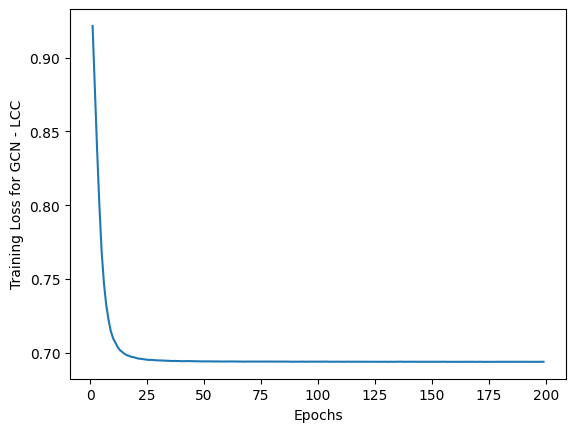

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epochs, total_loss)
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.ylabel('Training Loss for GCN - LCC')
plt.show()

In [ ]:
micro_f1,macro_f1,macro_AUC_ROC,ap_score_1 = test_GraphSage(model_SAGE_lcc, test_loader)
print("micro_f1:", micro_f1)
print("macro_f1:", macro_f1)
print("macro_AUC_ROC:", macro_AUC_ROC)
print("ap_score:", ap_score_1)

micro_f1: 0.3761524277811924
macro_f1: 0.042823485243878495
macro_AUC_ROC: 0.5264783948000086
ap_score: 0.057392981817919325


In [ ]:
# Train loop
epochs = list(range(1, 200))
total_loss = []
for epoch in epochs:
  loss = train_lcc(gat_model_lcc)
  total_loss.append(float(loss))
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epochs, total_loss)
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.ylabel('Training Loss for GCN - LCC')
plt.show()

In [ ]:
micro_f1,macro_f1,macro_AUC_ROC,ap_score_1 = test(gat_model_lcc)
print("micro_f1:", micro_f1)
print("macro_f1:", macro_f1)
print("macro_AUC_ROC:", macro_AUC_ROC)
print("ap_score:", ap_score_1)

In [ ]:
model_normal = GCN(hidden_channels=32)
gat_model_normal = GAT(hidden_channels, num_heads)
gat_model_normal = GAT(hidden_channels, num_heads)
#Graph SAGE
model_SAGE_normal = SAGE(in_channels=Euka.x.shape[1],
                 hidden_channels=32,
                 class_channels=Euka.y.shape[1],
                 )

In [ ]:
# decide which model to use
optimizer = torch.optim.Adam(model_SAGE_normal.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Train loop
epochs = list(range(1, 200))
total_loss = []
for epoch in epochs:
  loss = train_normal(gat_model_normal)
  total_loss.append(float(loss))
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epochs, total_loss)
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.ylabel('Training Loss for GCN - LCC')
plt.show()

In [ ]:
micro_f1,macro_f1,macro_AUC_ROC,ap_score_1 = test(gat_model_normal)
print("micro_f1:", micro_f1)
print("macro_f1:", macro_f1)
print("macro_AUC_ROC:", macro_AUC_ROC)
print("ap_score:", ap_score_1)

In [ ]:
def list_difference(list1, list2):
    # 将列表转换为集合，方便计算差异
    set1 = set(list1)
    set2 = set(list2)
    # 计算两个集合的对称差
    difference = set1.symmetric_difference(set2)
    # 将结果转换为列表并返回
    return list(difference)

missing_label_index = list_difference(columns_count_lcc, list(range(Euka.y.shape[1])))
print(missing_label_index)

[4, 5, 12]


In [ ]:
def get_nonzero_row_indices(tensor, n):
    # 检查第 n 列不为 0 的行
    nonzero_indices = torch.nonzero(tensor[:, n]).squeeze()

    # 返回行的索引
    return nonzero_indices

def sample_indices(indices, num_samples):
    # 从 indices 中随机抽取 num_samples 个索引
    sampled_indices = indices[torch.randint(len(indices), (num_samples,))]
    return sampled_indices

#num_samples = 100
enriching_index = torch.tensor([])
for column_index in missing_label_index:
    nonzero_row_indices = get_nonzero_row_indices(labels, column_index)
    enriching_index = torch.cat((enriching_index, nonzero_row_indices))
unique_enriching_index = torch.unique(enriching_index)
unique_enriching_index.shape

torch.Size([474])

In [ ]:
#only modifying training_mask, 对training_mask做进一步挑选，挑选出只在largest connected component 出现过的节点
def enrich_train_mask(train_mask, node_list):
    node_set = set(node_list)  # 将node_list转换为集合以便快速查找
    updated_mask = train_mask.clone()  # 复制 train_mask，以免修改原始数据
    print(updated_mask)
    for idx in range(train_mask.size(0)):
        if (updated_mask[idx] == False) and (idx in node_set):
            updated_mask[idx] = True
    return updated_mask

unique_enriching_index_list = [int(x) for x in unique_enriching_index.tolist()]
train_mask_lcc_enriching = enrich_train_mask(train_mask_lcc, unique_enriching_index_list)
true_count_enriching = count_true_values(train_mask_lcc_enriching)
print("Number of True values:", true_count_enriching)

tensor([False,  True, False,  ..., False, False, False])
Number of True values: 2094


In [ ]:
model_lcc_enrich = GCN(hidden_channels=32)
gat_model_enrich = GAT(hidden_channels, num_heads)
model_SAGE_enrich = SAGE(in_channels=Euka.x.shape[1],
                 hidden_channels=32,
                 class_channels=Euka.y.shape[1],
                 )

train_loader_enrich = NeighborLoader(Euka,input_nodes=train_mask_lcc_enriching,
                              num_neighbors=[5, 3],
                              shuffle=True, batch_size = 512)

In [ ]:
# decide which model to use
optimizer = torch.optim.Adam(model_SAGE_enrich.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Train loop
epochs = list(range(1, 200))
total_loss = []
for epoch in epochs:
  loss = train_GraphSage(model_SAGE_enrich,train_loader_enrich)
  total_loss.append(float(loss))
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 0.9284
Epoch: 002, Loss: 0.9027
Epoch: 003, Loss: 0.8767
Epoch: 004, Loss: 0.8517
Epoch: 005, Loss: 0.8263
Epoch: 006, Loss: 0.8052
Epoch: 007, Loss: 0.7833
Epoch: 008, Loss: 0.7665
Epoch: 009, Loss: 0.7530
Epoch: 010, Loss: 0.7422
Epoch: 011, Loss: 0.7345
Epoch: 012, Loss: 0.7279
Epoch: 013, Loss: 0.7228
Epoch: 014, Loss: 0.7178
Epoch: 015, Loss: 0.7146
Epoch: 016, Loss: 0.7123
Epoch: 017, Loss: 0.7093
Epoch: 018, Loss: 0.7077
Epoch: 019, Loss: 0.7061
Epoch: 020, Loss: 0.7044
Epoch: 021, Loss: 0.7034
Epoch: 022, Loss: 0.7023
Epoch: 023, Loss: 0.7015
Epoch: 024, Loss: 0.7005
Epoch: 025, Loss: 0.7000
Epoch: 026, Loss: 0.6995
Epoch: 027, Loss: 0.6989
Epoch: 028, Loss: 0.6987
Epoch: 029, Loss: 0.6981
Epoch: 030, Loss: 0.6979
Epoch: 031, Loss: 0.6976
Epoch: 032, Loss: 0.6973
Epoch: 033, Loss: 0.6972
Epoch: 034, Loss: 0.6969
Epoch: 035, Loss: 0.6966
Epoch: 036, Loss: 0.6965
Epoch: 037, Loss: 0.6962
Epoch: 038, Loss: 0.6961
Epoch: 039, Loss: 0.6961
Epoch: 040, Loss: 0.6959


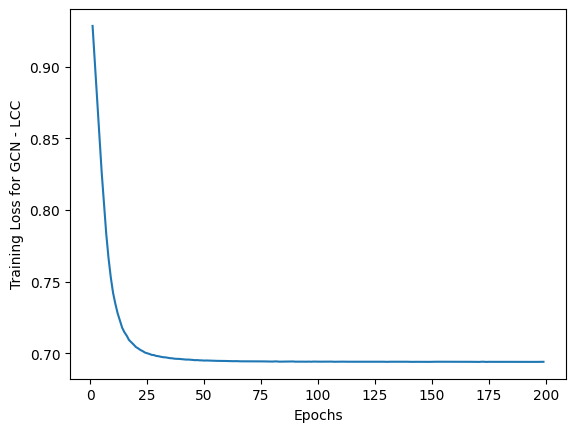

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epochs, total_loss)
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.ylabel('Training Loss for GCN - LCC')
plt.show()

In [ ]:
micro_f1,macro_f1,macro_AUC_ROC,ap_score_1 = test(gat_model_enrich)
print("micro_f1:", micro_f1)
print("macro_f1:", macro_f1)
print("macro_AUC_ROC:", macro_AUC_ROC)
print("ap_score:", ap_score_1)

In [ ]:
#test_GraphSage(model_SAGE_enrich,test_loader)

(0.3840257648953301,
 0.04301153799488881,
 0.5280013940733972,
 0.05675044744368845)

Sample nodes with high homophily

In [ ]:
# import torch
# from torch_geometric.loader import NeighborLoader
# from torch_geometric.data import Data
# from sklearn.metrics import jaccard_score
# import random

# class DegreeNeighborSampler:
#   def __init__(self, data):
#       self.data = data
#       self.graph = G_Euka

#   def sample(self, batch, sizes):
#     size1, size2 = sizes  # 第一层和第二层邻居采样的节点数量

#     sampled_nodes_mask = torch.zeros(self.data.num_nodes, dtype=torch.bool)

#     for node in batch:
#         node = node.item()
#         homophily_node_dic = {}

#         # 第一层邻居采样
#         for neighbor in list(self.graph.neighbors(node)):
#             homophily_node = jaccard_score(self.data.y[node].numpy(), self.data.y[neighbor].numpy())
#             homophily_node_dic[neighbor] = homophily_node

#         sorted_neighbors = sorted(homophily_node_dic, key=homophily_node_dic.get, reverse=True)
#         first_layer_neighbors = sorted_neighbors[:size1]

#         # 第二层邻居采样
#         second_layer_neighbors = []
#         for neighbor in first_layer_neighbors:
#             second_neighbors = list(self.graph.neighbors(neighbor))
#             random.shuffle(second_neighbors)
#             second_layer_neighbors.extend(second_neighbors[:size2])

#         # 设置节点掩码
#         sampled_nodes_mask[node] = True
#         for neighbor in first_layer_neighbors:
#             sampled_nodes_mask[neighbor] = True
#             for second_neighbor in list(self.graph.neighbors(neighbor))[:size2]:
#                 sampled_nodes_mask[second_neighbor] = True

#     return sampled_nodes_mask


# class CustomNeighborLoader(NeighborLoader):
#   def __init__(self, data, input_nodes, sampler, num_neighbors, batch_size, shuffle=True):
#       self.data = data
#       self.custom_sampler = sampler
#       self.num_neighbors = num_neighbors
#       super(CustomNeighborLoader, self).__init__(data, num_neighbors, input_nodes=input_nodes, batch_size=batch_size, shuffle=shuffle)

#   def __iter__(self):
#       for batch in super(CustomNeighborLoader, self).__iter__():
#           sampled_nodes = self.custom_sampler.sample(batch.n_id, self.num_neighbors)
#           yield sampled_nodes


In [ ]:
# def train_GraphSage_improved(model, loader):
#   model.train()
#   total_loss = 0
#   for data in loader:
#     print(data[0].shape)
#     print(data[1].shape)
#     print(data[2].shape)
#     optimizer.zero_grad()
#     output = model(data[0], data[1])
#     loss = criterion(output, data[2])  # Assuming classification task
#     loss.backward()
#     optimizer.step()
#     total_loss += loss.item()
#   return total_loss / len(loader)

In [ ]:
# # 创建 DegreeNeighborSampler 实例
# sampler = DegreeNeighborSampler(Euka)

# # 使用自定义 NeighborLoader
# train_loader_Sage_improved = CustomNeighborLoader(Euka, input_nodes=train_mask,
#                                    sampler=sampler, num_neighbors=[5, 3],
#                                    batch_size=512, shuffle=True)
# model_SAGE_normal.train()
# total_loss = 0
# for data in train_loader_Sage_improved:
#   optimizer.zero_grad()
#   output = model_SAGE_normal.forward(Euka.x, Euka.edge_index)
#   loss = criterion(output[data], Euka.y[data])
#   loss.backward()
#   optimizer.step()
#   total_loss += loss.item()
